# Sinkhorn divergences

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaOptimalTransport/OptimalTransport.jl/blob/master/examples/empirical_sinkhorn_div/script.jl).
The rendered HTML can be viewed [in the docs](https://juliaoptimaltransport.github.io/OptimalTransport.jl/dev/examples/empirical_sinkhorn_div/).*

In this tutorial we provide a minimal example for using the Sinkhorn divergence as a loss function [FSV+19] on empirical distributions.
[FSV+19]: Feydy, Jean, et al. "Interpolating between optimal transport and MMD using Sinkhorn divergences." The 22nd International Conference on Artificial Intelligence and Statistics. PMLR, 2019.

While entropy-regularised optimal transport $\operatorname{OT}_{\varepsilon}(\cdot, \cdot)$ is commonly used as a loss function, it suffers from a problem of *bias*: namely that $\nu \mapsto \operatorname{OT}_{\varepsilon}(\mu, \nu)$ is *not* minimised at $\nu = \mu$.

A fix to this problem is proposed by Genevay et al [GPC18] and subsequently Feydy et al. [FSV+19], which introduce the *Sinkhorn divergence* between two measures $\mu$ and $\nu$, defined as
$$
\operatorname{S}_{\varepsilon}(\mu, \nu) = \operatorname{OT}_{\varepsilon}(\mu, \nu) - \frac{1}{2} \operatorname{OT}_{\varepsilon}(\mu, \mu) - \frac{1}{2} \operatorname{OT}_{\varepsilon}(\nu, \nu).
$$
In the above, we have followed the convention taken by Feydy et al. and included the entropic regularisation in the definition of $\operatorname{OT}_\varepsilon$.
[GPC18]: Aude Genevay, Gabriel Peyré, Marco Cuturi, Learning Generative Models with Sinkhorn Divergences, Proceedings of the Twenty-First International Conference on Artficial Intelligence and Statistics, (AISTATS) 21, 2018
[FSV+19]: Feydy, Jean, et al. "Interpolating between optimal transport and MMD using Sinkhorn divergences." The 22nd International Conference on Artificial Intelligence and Statistics. PMLR, 2019.

Like the Sinkhorn loss, the Sinkhorn divergence is smooth and convex in both of its arguments. However, the Sinkhorn divergence is unbiased -- i.e. $S_{\varepsilon}(\mu, \nu) = 0$ iff $\mu = \nu$.

Unlike previous examples, here we demonstrate a learning problem similar to Figure 1 of Feydy et al. over *empirical measures*, i.e. measures that have the form $\mu = \frac{1}{N} \sum_{i = 1}^{N} \delta_{x_i}$ where $\delta_x$ is the Dirac delta function at $x$.

We first load packages.

In [1]:
using OptimalTransport
using ReverseDiff
using Distributions
using LinearAlgebra
using Distances
using Plots
using Logging
using Optim

As a ground truth distribution, we set $\rho$ to be a Gaussian mixture model with `k = 3` components, equally spaced around a circle, and sample an empirical distribution of size $N$, $\mu \sim \rho$.

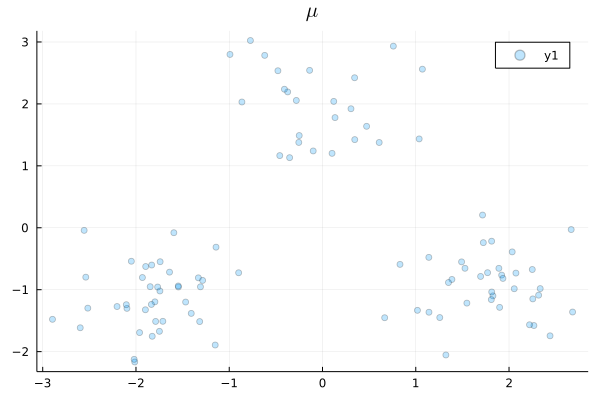

In [2]:
k = 3
d = 2
θ = π * range(0, 2(1 - 1 / k); length=k)
μ = 2 * hcat(sin.(θ), cos.(θ))
ρ = MixtureModel(MvNormal[MvNormal(x, 0.25 * I) for x in eachrow(μ)])
N = 100
μ_spt = rand(ρ, N)'
scatter(μ_spt[:, 1], μ_spt[:, 2]; markeralpha=0.25, title=raw"$\mu$")

Now, suppose we want to approximate $\mu$ with another empirical distribution $\nu$, i.e. we want to minimise $\nu \mapsto \operatorname{S}_{\varepsilon}(\mu, \nu)$ over possible empirical distributions $\nu$. In this case we have $M$ particles in $\nu$, which we initialise following a Gaussian distribution.

In [3]:
M = 100
ν_spt = rand(M, d);

Assign uniform weights to the Diracs in each empirical distribution.

In [4]:
μ = fill(1 / N, N)
ν = fill(1 / M, M);

Since $\mu$ is fixed, we pre-compute the cost matrix $C_{\mu}$.

In [5]:
C_μ = pairwise(SqEuclidean(), μ_spt');

Define the loss function to minimise, where `x` specifies the locations of the Diracs in $\nu$.

We will be using `ReverseDiff` with a precompiled tape. For this reason, we need the Sinkhorn algorithm to perform a fixed number of (e.g. 50) iterations.
Currently, this can be achieved by setting `maxiter = 50` and `atol = rtol = 0` in calls to `sinkhorn` and `sinkhorn_divergence`.

In [6]:
function loss(x, ε)
    C_μν = pairwise(SqEuclidean(), μ_spt', x')
    C_ν = pairwise(SqEuclidean(), x')
    return sinkhorn_divergence(
        μ, ν, C_μν, C_μ, C_ν, ε; maxiter=50, atol=rtol = 0, regularization=true
    )
end

loss (generic function with 1 method)

Set entropy regularisation parameter

In [7]:
ε = 1.0;

Use ReverseDiff with a precompiled tape and Optim.jl to minimise $\nu \mapsto \operatorname{S}_{\varepsilon}(\mu, \nu)$. Note that this is problem is *not* convex, so we find a local minimium.

In [8]:
const loss_tape = ReverseDiff.GradientTape(x -> loss(x, ε), ν_spt)
const compiled_loss_tape = ReverseDiff.compile(loss_tape)
opt = with_logger(SimpleLogger(stderr, Logging.Error)) do
    optimize(
        x -> loss(x, ε),
        (∇, x) -> ReverseDiff.gradient!(∇, compiled_loss_tape, x),
        ν_spt,
        GradientDescent(),
        Optim.Options(; iterations=10, g_tol=1e-6, show_trace=true),
    )
end
ν_opt = Optim.minimizer(opt)
plt1 = scatter(μ_spt[:, 1], μ_spt[:, 2]; markeralpha=0.25, title="Sinkhorn divergence")
scatter!(plt1, ν_opt[:, 1], ν_opt[:, 2]);

Iter     Function value   Gradient norm 
     0     4.025977e+00     4.419336e-02
 * time: 7.915496826171875e-5
     1     3.666939e-01     1.910695e-02
 * time: 1.7578980922698975
     2     4.696609e-02     8.809322e-03
 * time: 2.339888095855713
     3     1.825875e-02     6.396794e-03
 * time: 3.4850080013275146
     4     4.841494e-03     2.477463e-03
 * time: 4.166520118713379
     5     2.138573e-03     1.430849e-03
 * time: 5.170143127441406
     6     1.508188e-03     6.912626e-04
 * time: 6.073405027389526
     7     1.215883e-03     5.052778e-04
 * time: 7.128062009811401
     8     1.027211e-03     3.834124e-04
 * time: 8.220916032791138
     9     9.127460e-04     3.792193e-04
 * time: 9.134607076644897
    10     8.189650e-04     3.095089e-04
 * time: 10.127689123153687


For comparison, let us do the same computation again, but this time we want to minimise $\nu \mapsto \operatorname{OT}_{\varepsilon}(\mu, \nu)$.

In [9]:
function loss_biased(x, ε)
    C_μν = pairwise(SqEuclidean(), μ_spt', x')
    return sinkhorn2(μ, ν, C_μν, ε; maxiter=50, atol=rtol = 0, regularization=true)
end
const loss_biased_tape = ReverseDiff.GradientTape(x -> loss_biased(x, ε), ν_spt)
const compiled_loss_biased_tape = ReverseDiff.compile(loss_biased_tape)
opt_biased = with_logger(SimpleLogger(stderr, Logging.Error)) do
    optimize(
        x -> loss_biased(x, ε),
        (∇, x) -> ReverseDiff.gradient!(∇, compiled_loss_biased_tape, x),
        ν_spt,
        GradientDescent(),
        Optim.Options(; iterations=10, g_tol=1e-6, show_trace=true),
    )
end
ν_opt_biased = Optim.minimizer(opt_biased)
plt2 = scatter(μ_spt[:, 1], μ_spt[:, 2]; markeralpha=0.25, title="Sinkhorn loss")
scatter!(plt2, ν_opt_biased[:, 1], ν_opt_biased[:, 2]);

Iter     Function value   Gradient norm 
     0    -4.115792e+00     3.675052e-02
 * time: 0.00010514259338378906
     1    -6.859034e+00     1.974000e-02
 * time: 1.1340901851654053
     2    -7.442054e+00     1.645285e-02
 * time: 1.70188307762146
     3    -7.550902e+00     9.287677e-03
 * time: 2.2752950191497803
     4    -7.589006e+00     1.025623e-02
 * time: 2.6167750358581543
     5    -7.592194e+00     1.542523e-02
 * time: 2.9606130123138428
     6    -7.607409e+00     1.579020e-03
 * time: 3.30007004737854
     7    -7.607401e+00     1.486637e-03
 * time: 14.706472158432007
     8    -7.607394e+00     1.434005e-03
 * time: 27.83006715774536
     9    -7.607386e+00     1.392041e-03
 * time: 40.78367209434509
    10    -7.607379e+00     1.355530e-03
 * time: 53.3648681640625


Observe that the Sinkhorn divergence results in $\nu$ that matches $\mu$ quite well, while entropy-regularised transport is biased to producing $\nu$ that seems to concentrate around the mean of each Gaussian component.

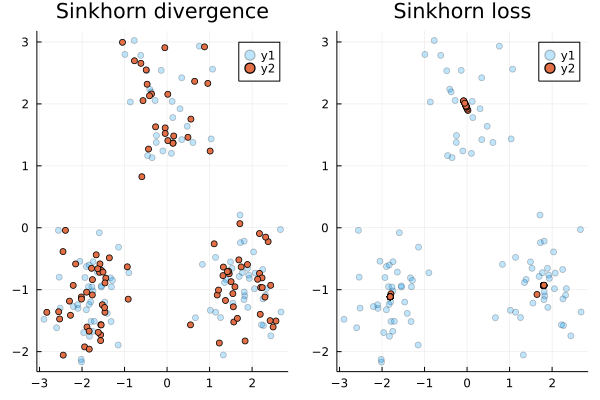

In [10]:
plot(plt1, plt2)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*